In [1]:
#@title Google Drive 마운트
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# @title Google Drive에서 파일 복사
import shutil
import os

# 파일 복사 함수
def copy_if_exists(source_path, destination_path):
    if os.path.exists(source_path):
        shutil.copy(source_path, destination_path)
        print(f"Copied: {source_path} to {destination_path}")
    else:
        print(f"File not found: {source_path}")

# Colab 내 저장 경로
tar_path                = "/content/sketch.tar"
best_model_path         = "/content/best_model.pth"
checkpoint_path         = "/content/sketch_classification_checkpoint.pth"

# Google Drive 파일 경로
remote_tar_path         = "/content/drive/MyDrive/colab/toy project sketch classification/clip/sketch.tar"
remote_best_model_path  = "/content/drive/MyDrive/colab/toy project sketch classification/clip/best_model.pth"
remote_checkpoint_path  = "/content/drive/MyDrive/colab/toy project sketch classification/clip/sketch_classification_checkpoint.pth"

# 파일 복사
copy_if_exists(remote_tar_path, tar_path)
copy_if_exists(remote_best_model_path, best_model_path)
copy_if_exists(remote_checkpoint_path, checkpoint_path)


Copied: /content/drive/MyDrive/colab/toy project sketch classification/clip/sketch.tar to /content/sketch.tar
Copied: /content/drive/MyDrive/colab/toy project sketch classification/clip/best_model.pth to /content/best_model.pth
Copied: /content/drive/MyDrive/colab/toy project sketch classification/clip/sketch_classification_checkpoint.pth to /content/sketch_classification_checkpoint.pth


In [3]:
# @title 파일 압축 풀기

import tarfile

# 파일 경로 및 대상 디렉토리 설정
extract_dir = "/content/dataset"

# 디렉토리 생성 (이미 존재하면 무시)
os.makedirs(extract_dir, exist_ok=True)

# tar 파일 압축 풀기
with tarfile.open(tar_path, "r") as tar:
    tar.extractall(path=extract_dir)

print(f"압축 해제 완료: {extract_dir}")

압축 해제 완료: /content/dataset


In [1]:
# @title 데이터셋 분리 (미리 수행해서 코드만 남김)

# import os
# import random
# import shutil

# # 데이터 경로 설정
# base_dir = "/content/images/tx_000000000000"
# train_dir = "/content/dataset/train"
# val_dir = "/content/dataset/val"
# test_dir = "/content/dataset/test"

# # 데이터셋 디렉토리 생성
# os.makedirs(train_dir, exist_ok=True)
# os.makedirs(val_dir, exist_ok=True)
# os.makedirs(test_dir, exist_ok=True)

# # 각 클래스 처리
# for class_name in os.listdir(base_dir):
#     class_path = os.path.join(base_dir, class_name)

#     if os.path.isdir(class_path):
#         # 이미지 파일 목록 가져오기
#         images = [os.path.join(class_path, img) for img in os.listdir(class_path) if img.endswith(".png")]

#         # 파일 무작위 셔플
#         random.shuffle(images)

#         # 파일 개수 계산
#         total_count = len(images)
#         train_count = int(total_count * 0.9)
#         val_count = int(total_count * 0.05)

#         # 데이터 분할
#         train_files = images[:train_count]
#         val_files = images[train_count:train_count + val_count]
#         test_files = images[train_count + val_count:]

#         # 파일 복사
#         for file in train_files:
#             class_train_dir = os.path.join(train_dir, class_name)
#             os.makedirs(class_train_dir, exist_ok=True)
#             shutil.copy(file, class_train_dir)

#         for file in val_files:
#             class_val_dir = os.path.join(val_dir, class_name)
#             os.makedirs(class_val_dir, exist_ok=True)
#             shutil.copy(file, class_val_dir)

#         for file in test_files:
#             class_test_dir = os.path.join(test_dir, class_name)
#             os.makedirs(class_test_dir, exist_ok=True)
#             shutil.copy(file, class_test_dir)

# print("데이터 분할 완료!")
# print(f"Training data saved in: {train_dir}")
# print(f"Validation data saved in: {val_dir}")
# print(f"Test data saved in: {test_dir}")


In [4]:
# @title 모델 학습/검증, 체크포인트 저장/불러오기 (공통사용)

import torch
from tqdm import tqdm

# import os

# 학습 함수
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss, correct = 0, 0
    progress_bar = tqdm(dataloader, desc="Training", leave=False)
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        progress_bar.set_postfix({"Loss": loss.item(), "Accuracy": correct / len(dataloader.dataset)})
    accuracy = correct / len(dataloader.dataset)
    return total_loss / len(dataloader), accuracy

# 평가 함수
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss, correct = 0, 0
    progress_bar = tqdm(dataloader, desc="Validating", leave=False)
    with torch.no_grad():
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            progress_bar.set_postfix({"Loss": loss.item(), "Accuracy": correct / len(dataloader.dataset)})
    accuracy = correct / len(dataloader.dataset)
    return total_loss / len(dataloader), accuracy

# 체크포인트 저장 함수
def save_checkpoint(model, optimizer, epoch, train_history, val_history, best_val_acc, checkpoint_path):
    checkpoint = {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": epoch,
        "train_history": train_history,
        "val_history": val_history,
        "best_val_acc": best_val_acc,
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved at epoch {epoch} with Validation Accuracy: {best_val_acc:.4f}")

# 체크포인트 불러오기 함수
def load_checkpoint(checkpoint_path, model, optimizer):
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        epoch = checkpoint["epoch"]
        train_history = checkpoint["train_history"]
        val_history = checkpoint["val_history"]
        best_val_acc = checkpoint["best_val_acc"]
        print(f"Checkpoint loaded from epoch {epoch} with Validation Accuracy: {best_val_acc:.4f}")
        return epoch, train_history, val_history, best_val_acc
    else:
        print("No checkpoint found, starting from scratch.")
        return 0, [], [], 0.0

In [5]:
# @title 모델
from torch import nn
from transformers import CLIPModel

# CLIP 기반 분류 모델 정의
class SketchClassifier(nn.Module):
    def __init__(self, num_classes):
        super(SketchClassifier, self).__init__()
        self.clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        for param in self.clip_model.parameters():
            param.requires_grad = False  # CLIP 이미지 인코더 Freeze
        self.classifier = nn.Linear(512, num_classes)  # Linear Classifier 추가

    def forward(self, images):
        image_features = self.clip_model.get_image_features(pixel_values=images)
        logits = self.classifier(image_features)
        return logits


In [6]:
# @title 데이터셋, 데이터로더, 전처리기, 옵티마이저, 손실함수
from transformers import CLIPProcessor
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets

# 데이터셋 경로 설정
train_dir = "/content/dataset/train"
val_dir = "/content/dataset/val"
test_dir = "/content/dataset/test"

# CLIP 전처리기
pprocessor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# 데이터 로더 생성
def create_dataloader(data_dir, batch_size=32, shuffle=True):
    dataset = datasets.ImageFolder(data_dir, transform=lambda img: pprocessor(images=img, return_tensors="pt")["pixel_values"].squeeze(0))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader, dataset

train_loader, train_dataset = create_dataloader(train_dir, batch_size=512, shuffle=True)
val_loader, val_dataset = create_dataloader(val_dir, batch_size=512, shuffle=False)
test_loader, test_dataset = create_dataloader(test_dir, batch_size=512, shuffle=False)

# 모델 초기화
num_classes = len(train_dataset.classes)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SketchClassifier(num_classes).to(device)
best_model = SketchClassifier(num_classes).to(device)

# 손실 함수 및 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

<ipython-input-4-0c3644f6f7c9>:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Checkpoint loaded from epoch 30 with Validation Accuracy: 0.8304


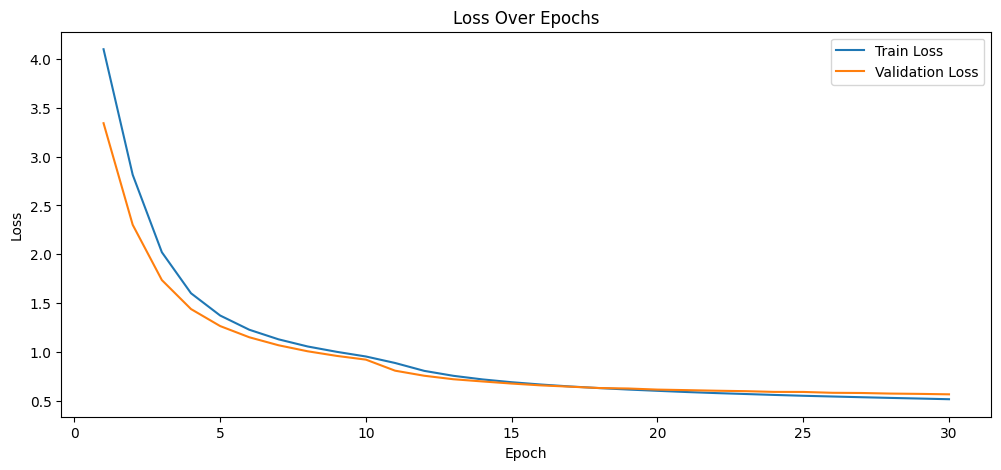

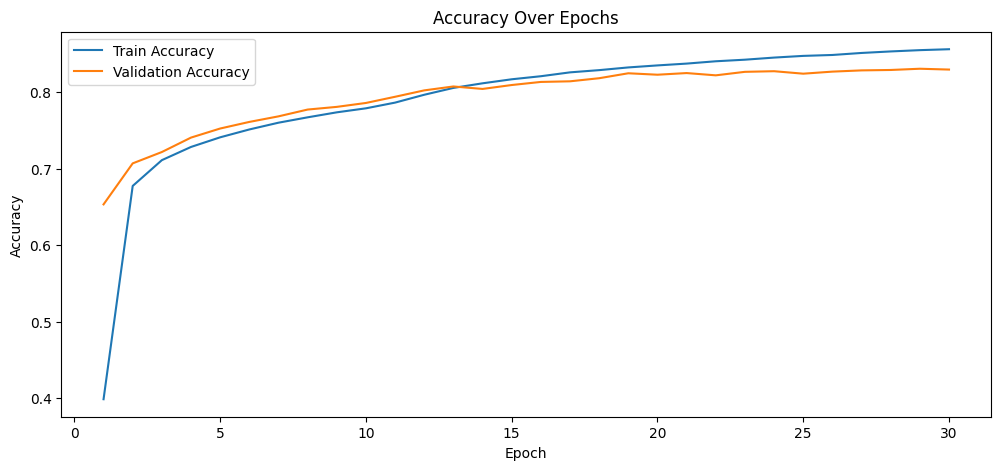

In [7]:
# @title 학습, 시각화

import torch
import matplotlib.pyplot as plt

# 학습 설정
num_epochs = 0

# 초기화 또는 체크포인트 불러오기
start_epoch, train_history, val_history, best_val_acc = load_checkpoint(checkpoint_path, model, optimizer)

# 학습 루프
for epoch in range(start_epoch, num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    # 기록 업데이트
    train_history.append((train_loss, train_acc))
    val_history.append((val_loss, val_acc))

    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # 최고 성능 모델 저장
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"  Best model saved with Validation Accuracy: {best_val_acc:.4f}")

    # 체크포인트 저장
    save_checkpoint(model, optimizer, epoch+1, train_history, val_history, best_val_acc, checkpoint_path)

# 기록 시각화
epochs = range(1, len(train_history) + 1)
train_losses, train_accuracies = zip(*train_history)
val_losses, val_accuracies = zip(*val_history)

plt.figure(figsize=(12, 5))
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs")
plt.legend()
plt.show()

In [8]:
# 테스트 평가
best_model.load_state_dict(torch.load(best_model_path))
test_loss, test_acc = evaluate(best_model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

<ipython-input-8-03efa379dbfa>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_path))
                                     

Test Loss: 0.6288, Test Acc: 0.8221


In [ ]:
# @title 결과 파일 복사
copy_if_exists(best_model_path, remote_best_model_path)
copy_if_exists(checkpoint_path, remote_checkpoint_path)

Copied: /content/best_model.pth to /content/drive/MyDrive/colab/toy project sketch classification/best_model.pth
Copied: /content/sketch_classification_checkpoint.pth to /content/drive/MyDrive/colab/toy project sketch classification/sketch_classification_checkpoint.pth


In [9]:
from google.colab import runtime
runtime.unassign()